/home/dronelab/delaunay_rasterization


2025-02-25 14:06:08.055967: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Num gt: 1024 vs Pred: None
tensor([[0, 0, 8, 8]], device='cuda:0', dtype=torch.int32)
Vertex Torch Grad: [[ 0.60762703 -0.26948455  1.3928127 ]
 [ 0.71038866 -1.1174556  -2.7907186 ]
 [ 1.0950516   1.4910204   3.7831721 ]
 [-0.54384637 -2.073495   -3.755086  ]]
Vertex Jax Grad: [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.8789483   0.12253952  2.406251  ]
 [ 0.          0.          0.        ]]
RGBS Torch Grad: [[0.04120973 0.04120973 0.04120972 0.01135354]]
RGBS Jax Grad: [[0.02476354 0.02476354 0.02476354 0.00708005]]
Max value torch: 0.270041286945343
Max value jax: 0.20420700311660767
Mean Error: 0.04933853819966316
Max Error: 0.1457333266735077


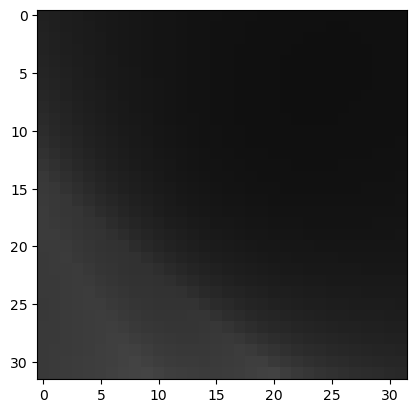

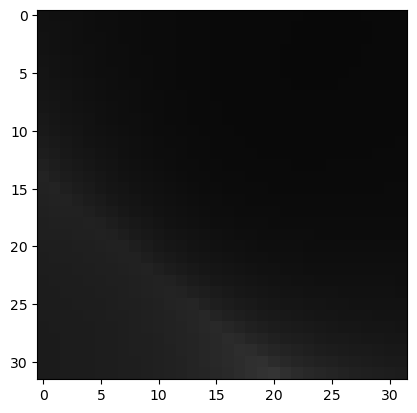

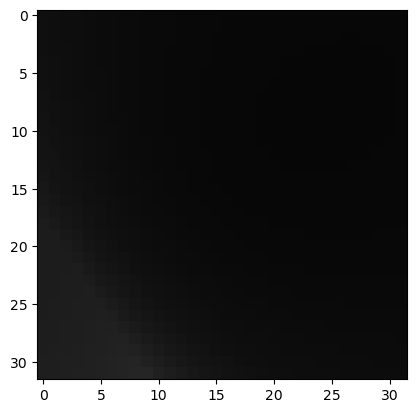

In [1]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from utils.compare_quad import test_tetrahedra_rendering
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create sample tetrahedra
torch.manual_seed(0)
N = 4
vertices = (torch.rand((N, 3)).cuda() * 2 - 1) * 100
indices = torch.tensor([[0, 1, 2, 3]]).int().cuda()
rgbs = torch.ones(1, 4).cuda()
rgbs[:, 3] = 10


# Generate random barycentric coordinates that sum to 1
barycentric = torch.rand(4).cuda()
barycentric = barycentric / barycentric.sum()

# Use barycentric coordinates to get a point inside the tetrahedron
origin = vertices[indices[0]].T @ barycentric  # Shape: (3,)

# Update viewmat with new origin
viewmat = torch.eye(4)
viewmat[:3, 3] = origin  # Set translation to sampled point
viewmat = torch.linalg.inv(viewmat)
vertices = torch.tensor([[-0.0954798982, -0.0576470010,  0.0907066390],
        [-0.0794274211, -0.0494611152,  0.0444854014],
        [-0.0524959937,  0.0647660419,  0.0939735770],
        [-0.0065456270,  0.0679433569,  0.0750745535]], device='cuda:0')
viewmat = torch.tensor([[-0.8002946973, -0.5985016227,  0.0363887995, -0.0098749101],
        [-0.4739684165,  0.6686108708,  0.5729864836, -0.0947880447],
        [ 0.3672632575, -0.4413108826,  0.8187565804,  0.6489951611],
        [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
       device='cuda:0')
vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
        [ 0.2899414003, -0.1144087315,  0.2279857695],
        [-0.3941484988,  0.2187604010,  0.3265861571],
        [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
viewmat = torch.tensor([[ 9.2208576202e-01, -3.7686905265e-01,  8.7907373905e-02,
          8.3750230260e-05],
        [ 3.0987361446e-02,  2.9833433032e-01,  9.5395827293e-01,
         -2.2361640632e-01],
        [ 3.8574317098e-01,  8.7690722942e-01, -2.8676798940e-01,
          1.9718817472e+00],
        [ 2.1461694644e-09, -2.4329395387e-08, -3.2908822334e-09,
          1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[-0.3819195926, -0.2305880040,  0.3628265560],
#         [-0.3177096844, -0.1978444606,  0.1779416054],
#         [-0.2099839747,  0.2590641677,  0.3758943081],
#         [-0.0261825081,  0.2717734277,  0.3002982140]], device='cuda:0')
# viewmat = torch.tensor([[ 8.0029475689e-01,  5.9850162268e-01, -3.6388747394e-02,
#           3.9499610662e-02],
#         [-4.7396835685e-01,  6.6861087084e-01,  5.7298648357e-01,
#          -3.7915235758e-01],
#         [-3.6726331711e-01,  4.4131094217e-01, -8.1875652075e-01,
#           1.0243387222e+00],
#         [-1.3238860674e-08, -6.2472373941e-09,  2.1942579309e-08,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[ 9.2208570242e-01, -3.7686908245e-01,  8.7907396257e-02,
#           8.3774328232e-05],
#         [ 3.0987352133e-02,  2.9833433032e-01,  9.5395833254e-01,
#          -2.2361648083e-01],
#         [ 3.8574314117e-01,  8.7690728903e-01, -2.8676798940e-01,
#           7.0029509068e-01],
#         [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00,
#           1.0000000000e+00]], device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.4876191318, -0.8475935459, -0.2093149424, -0.0044252351],
#         [-0.8258575201,  0.5255668759, -0.2043008804,  0.1754622161],
#         [ 0.2831731141,  0.0732432902, -0.9562679529,  0.2541924715],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')
# vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
#         [ 0.2899414003, -0.1144087315,  0.2279857695],
#         [-0.3941484988,  0.2187604010,  0.3265861571],
#         [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
# viewmat = torch.tensor([[-0.7677200437,  0.1756590605,  0.6162384152, -0.0968539640],
#         [ 0.3055213988,  0.9456868172,  0.1110551804,  0.0558680296],
#         [-0.5632607341,  0.2735333145, -0.7796902657,  0.2879556417],
#         [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
#        device='cuda:0')
vertices = torch.tensor([[ 0.0303834435, -0.0484241247,  0.0472706556],
        [ 0.0362426750, -0.0143010914,  0.0284982212],
        [-0.0492685623,  0.0273450501,  0.0408232696],
        [-0.0420121364,  0.0174846780,  0.0204321742]], device='cuda:0')
viewmat = torch.tensor([[ 0.0589137860,  0.9978331327, -0.0292952899,  0.0147890374],
        [-0.9375914931,  0.0452345237, -0.3447842002,  0.0209230129],
        [-0.3427119553,  0.0477795564,  0.9382247329, -0.0288869385],
        [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
       device='cuda:0')

# Run test
results = test_tetrahedra_rendering(
    vertices.cuda(), indices, rgbs, viewmat,
    height=32, width=32, tile_size=4, fov=130)
    # height=8, width=8)

print(f"Num gt: {(results['torch_image'] > 0).sum()//3} vs Pred: {results['tet_area']}")
print(results['rect_tile_space'])
print(f"Vertex Torch Grad: {results['torch_vertex_grad']}")
print(f"Vertex Jax Grad: {results['jax_vertex_grad']}")
print(f"RGBS Torch Grad: {results['torch_rgbs_grad']}")
print(f"RGBS Jax Grad: {results['jax_rgbs_grad']}")
print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")
plt.imshow(results['torch_image'])
plt.show()
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()

In [2]:
from jaxutil import tetra_quad
import jax.numpy as jnp
cam_pos = jnp.linalg.inv(viewmat.cpu().numpy())[:3, 3]
print(vertices, indices)
tetra_quad.point_in_tetrahedron(vertices.cpu().numpy(), indices.cpu().numpy()[0], cam_pos)

tensor([[ 0.0304, -0.0484,  0.0473],
        [ 0.0362, -0.0143,  0.0285],
        [-0.0493,  0.0273,  0.0408],
        [-0.0420,  0.0175,  0.0204]], device='cuda:0') tensor([[0, 1, 2, 3]], device='cuda:0', dtype=torch.int32)


Array(True, dtype=bool)

In [3]:

print(vertices, viewmat)
print(viewmat @ torch.cat([vertices.T, torch.ones_like(vertices.T[:1, :])], dim=0))

tensor([[ 0.0304, -0.0484,  0.0473],
        [ 0.0362, -0.0143,  0.0285],
        [-0.0493,  0.0273,  0.0408],
        [-0.0420,  0.0175,  0.0204]], device='cuda:0') tensor([[ 0.0589,  0.9978, -0.0293,  0.0148],
        [-0.9376,  0.0452, -0.3448,  0.0209],
        [-0.3427,  0.0478,  0.9382, -0.0289],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
tensor([[-0.0331,  0.0018,  0.0380,  0.0292],
        [-0.0261, -0.0235,  0.0543,  0.0541],
        [ 0.0027, -0.0153,  0.0276,  0.0055],
        [ 1.0000,  1.0000,  1.0000,  1.0000]], device='cuda:0')


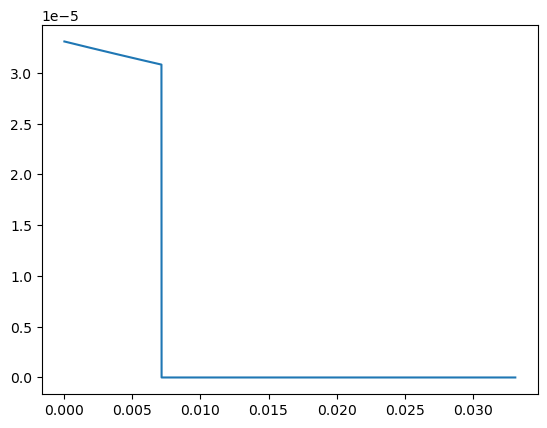

[3.3130416e-06 6.6260832e-06 9.9391245e-06 ... 3.3120476e-02 3.3123791e-02
 3.3127103e-02]


In [4]:

i, j = 0, 0
plt.plot(results['extras']['tdist'][i, j][1:], results['extras']['weights'][i, j][0])
plt.show()
print(results['extras']['tdist'][i, j][1:])